# GAN Basic

## Getting Started
Import some useful packages and the dataset you will use to build and train your GAN

In [1]:
import os
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
%matplotlib inline

## Configurations

In [2]:
# Hyper-parameters
latent_size = 96
hidden_size = 1024
image_size = 784
num_epochs = 10
batch_size = 256

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Import MNIST Dataset

In [3]:
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5],   # 1 for greyscale channels
                                     std=[0.5])])

# MNIST dataset
mnist = torchvision.datasets.MNIST(root='data',
                                   train=True,
                                   transform=transform,
                                   download=True)

# Data loader
data_loader = torch.utils.data.DataLoader(dataset=mnist,
                                          batch_size=batch_size, 
                                          shuffle=True)

## Discriminator and Generator

In [4]:
# Discriminator
D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.01),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.01),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

# Generator 
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.LeakyReLU(0.01),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.01),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

def initialize_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.ConvTranspose2d):
        nn.init.xavier_uniform_(m.weight.data)

# Device setting
D = D.to(device)
G = G.to(device)
D.apply(initialize_weights)
G.apply(initialize_weights)

# Binary cross entropy loss and optimizer
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.002, betas=(0.5,0.999))
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.002, betas=(0.5,0.999))

## Training and Visualization

Epoch [0/10], Step [200/235], gscore: 0.5046, dscore: 0.6110


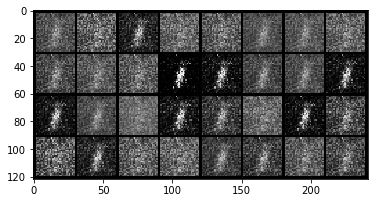

Epoch [1/10], Step [200/235], gscore: 0.1421, dscore: 0.5815


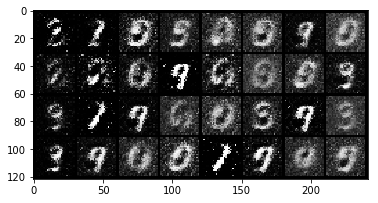

Epoch [2/10], Step [200/235], gscore: 0.4615, dscore: 0.5343


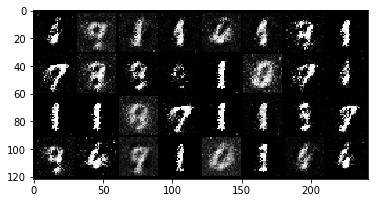

Epoch [3/10], Step [200/235], gscore: 0.4891, dscore: 0.5398


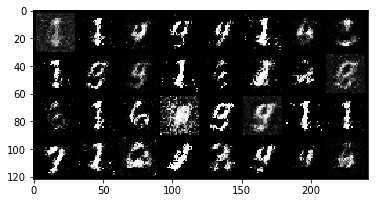

Epoch [4/10], Step [200/235], gscore: 0.3728, dscore: 0.5481


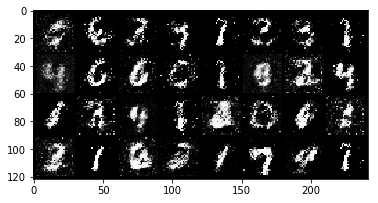

Epoch [5/10], Step [200/235], gscore: 0.4841, dscore: 0.5297


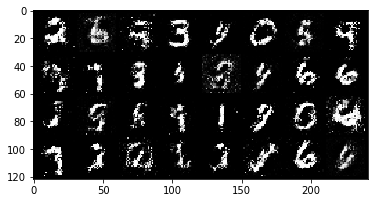

Epoch [6/10], Step [200/235], gscore: 0.5041, dscore: 0.5262


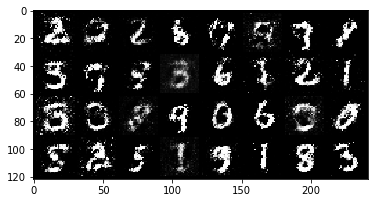

Epoch [7/10], Step [200/235], gscore: 0.3377, dscore: 0.5204


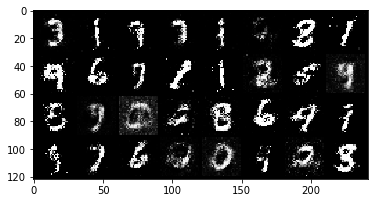

Epoch [8/10], Step [200/235], gscore: 0.4796, dscore: 0.5063


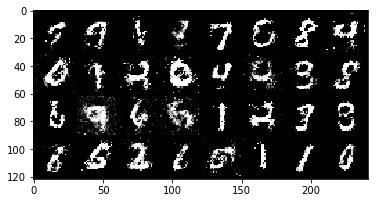

Epoch [9/10], Step [200/235], gscore: 0.4372, dscore: 0.5285


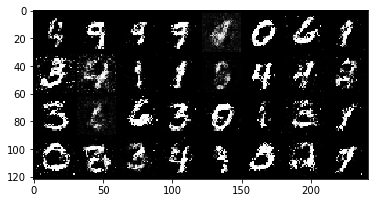

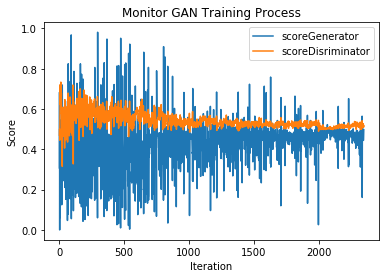

In [5]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

# Start training
total_step = len(data_loader)
gscores, dscores = [], []
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        b_size = images.shape[0]
        images = images.reshape(b_size, -1).to(device)
        
        # Create the labels which are later used as input for the BCE loss
        real_labels = torch.ones(b_size, 1).to(device)
        fake_labels = torch.zeros(b_size, 1).to(device)

        # ================================================================== #
        #                      Train the discriminator                       #
        # ================================================================== #

        # Compute BCE_Loss using real images where BCE_Loss(x, y): - y * log(D(x)) - (1-y) * log(1 - D(x))
        # Second term of the loss is always zero since real_labels == 1
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs
        
        # Compute BCELoss using fake images
        # First term of the loss is always zero since fake_labels == 0
        z = torch.randn(b_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs
        
        # Backprop and optimize
        d_loss = d_loss_real + d_loss_fake
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        dscore = real_score.mean().item() * 0.5 + (1-fake_score.mean()) * 0.5
        
        # ================================================================== #
        #                        Train the generator                         #
        # ================================================================== #

        # Compute loss with fake images
        z = torch.randn(b_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        
        # We train G to maximize log(D(G(z)) instead of minimizing log(1-D(G(z)))
        # For the reason, see the last paragraph of section 3. https://arxiv.org/pdf/1406.2661.pdf
        g_loss = criterion(outputs, real_labels)
        
        # Backprop and optimize
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
        gscore = outputs.mean().item()
        
        gscores.append(gscore)
        dscores.append(dscore)
        
        if (i+1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], gscore: {:.4f}, dscore: {:.4f}'.format(epoch, num_epochs, i+1, total_step, gscore, dscore))

            fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
            grid_img = vutils.make_grid(fake_images[:32].detach().cpu(), padding=2, normalize=True).permute(1, 2, 0).numpy()
            plt.imshow(grid_img)
            plt.show()

x_data=torch.arange(len(gscores))
l1,=plt.plot(x_data,gscores,label='scoreGenerator')
l2,=plt.plot(x_data,dscores,label='scoreDisriminator')
plt.xlabel('Iteration')
plt.ylabel('Score')
plt.title('Monitor GAN Training Process')
plt.legend()
plt.show()